In [89]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .appName("SimpleApp") \
    .getOrCreate()



### Reading data

In [90]:
df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("trip_fare.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("trip_data.parquet")

In [91]:
df_fare.show(3)

+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|vendor_id|    pickup_datetime|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|817884A641AB74A9F...|50B3AD56A59AAC39B...|      VTS|2013-04-12 12:12:00|         CSH|       39.0|      0.0|    0.5|       0.0|        5.33|       44.83|
|C4242CE6CCA4D6317...|1429D27200E0A56E7...|      VTS|2013-04-12 12:44:00|         CRD|        8.5|      0.0|    0.5|       1.7|         0.0|        10.7|
|090DFC82C624A617E...|1F50E9F425B005214...|      VTS|2013-04-12 12:41:00|         CSH|       10.0|      0.0|    0.5|       0.0|         0.0|        10.5|
+--------------------+--------------------+---------+-------------------+---

In [92]:
df_trip.show(3)

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|FE6449BC4837A48D5...|B261D0C6EB6679A9A...|      VTS|        1|              NULL|2013-04-21 01:10:00|2013-04-21 01:22:00|              6|              720|         2.78|      -73.996666|       40.71912|       -73.989433|       40.747963|
|6BD9973E3482EDC68...|1A1B92650B64B87A4...| 

### General Statistical Analysis
Finding <i>mean, standard deviation, median, min and max</i> for each of the numeric attributes in both fare and trip datasets.

In [93]:
def get_stats(df, col_name):
    return df.select(
        F.lit(col_name).alias("feature"),
        F.mean(col_name).alias("mean"),
        F.stddev(col_name).alias("stddev"),
        F.min(col_name).alias("min"),
        F.expr(f'percentile_approx({col_name}, 0.5)').alias("median"),
        F.max(col_name).alias("max")
    )

columns = ["fare_amount", "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"]

df_stats_list = [get_stats(df_fare, col) for col in columns]

df_stats = df_stats_list[0]
for df in df_stats_list[1:]:
    df_stats = df_stats.unionByName(df)

df_stats.show()

+------------+-------------------+-------------------+-------+------+---------+
|     feature|               mean|             stddev|    min|median|      max|
+------------+-------------------+-------------------+-------+------+---------+
| fare_amount| 12.350179522885133|  17.61781731486564|-1430.0|   9.5|158995.81|
|   surcharge| 0.3193474087811844|0.40936218031011173|  -19.5|   0.0|    854.5|
|     mta_tax|0.49820701788827404|0.03477811933973379|   -0.5|   0.5|    80.05|
|  tip_amount| 1.3651019019487773|  2.193723800085308| -96.82|   1.0|   888.19|
|tolls_amount|0.25002900899158964| 1.2135948056088939| -22.25|   0.0|   960.09|
|total_amount| 14.790096586143193|  69.02724740874783|-1430.0|  11.0| 685908.1|
+------------+-------------------+-------------------+-------+------+---------+



In [94]:
columns = ["trip_time_in_secs", "trip_distance", "passenger_count"]

df_stats_list = [get_stats(df_trip, col) for col in columns]
for df in df_stats_list[0:]:
    df_stats = df_stats.unionByName(df)

df_stats.show()


+-----------------+-------------------+-------------------+-------+------+---------+
|          feature|               mean|             stddev|    min|median|      max|
+-----------------+-------------------+-------------------+-------+------+---------+
|      fare_amount| 12.350179522885133|  17.61781731486564|-1430.0|   9.5|158995.81|
|        surcharge| 0.3193474087811844|0.40936218031011173|  -19.5|   0.0|    854.5|
|          mta_tax|0.49820701788827404|0.03477811933973379|   -0.5|   0.5|    80.05|
|       tip_amount| 1.3651019019487773|  2.193723800085308| -96.82|   1.0|   888.19|
|     tolls_amount|0.25002900899158964| 1.2135948056088939| -22.25|   0.0|   960.09|
|     total_amount| 14.790096586143193|  69.02724740874783|-1430.0|  11.0| 685908.1|
|trip_time_in_secs|  811.9999416964196| 15815.405665025506|-6480.0| 600.0|4294966.0|
|    trip_distance|  8.305137242741548| 6639.9030678122035|    0.0|   1.8|1.53318E7|
|  passenger_count| 1.7094193669596225| 1.3767439366809278|    0.

### Passenger Count
Taking a look at the count of trips with different passenger counts.

In [95]:
df_passenger_count = df_trip.select("passenger_count").groupBy("passenger_count").count().toPandas()
df_passenger_count.sort_values('passenger_count', inplace=True)
df_passenger_count['passenger_count'] = df_passenger_count['passenger_count'].astype(str)

/var/folders/vz/rgbmjfqn0nq0nvl3m3c5by_00000gn/T/ipykernel_38608/331447125.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='passenger_count', y='count', data=df_passenger_count, palette="Blues_d")


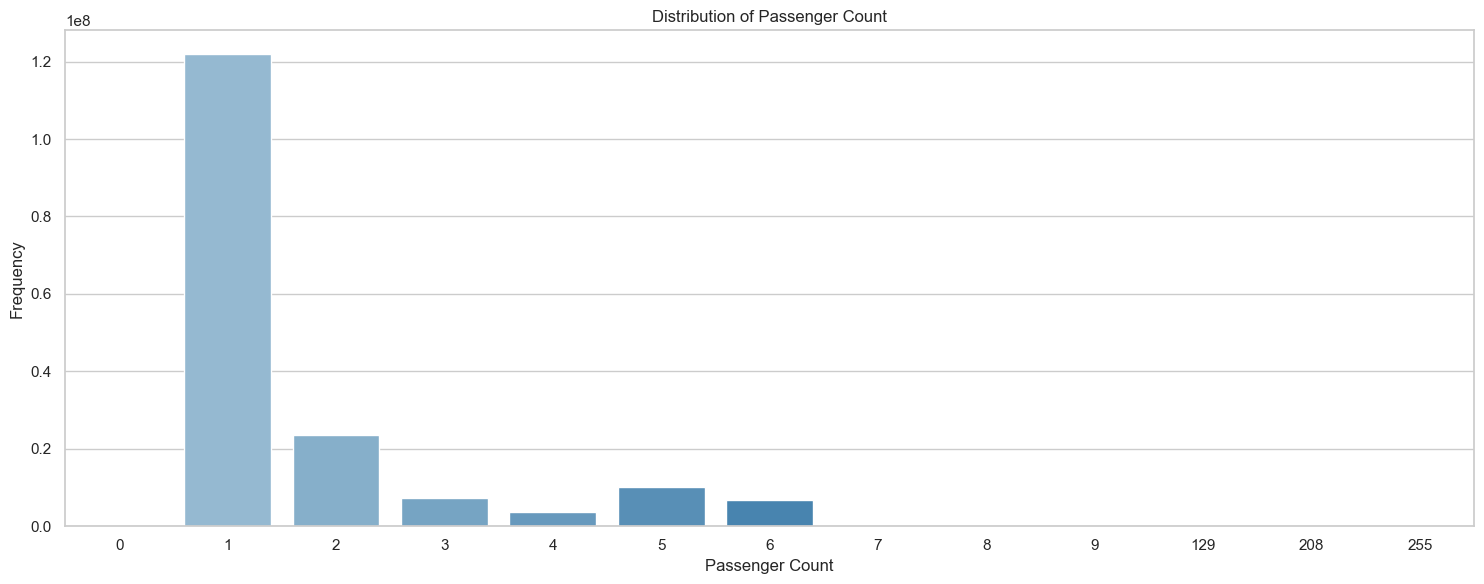

In [96]:
plt.figure(figsize=(15, 6))
sns.barplot(x='passenger_count', y='count', data=df_passenger_count, palette="Blues_d")
plt.title("Distribution of Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Total Amount
Finding how many negative and positive values are out there.

In [97]:
df_fare.where(df_fare['total_amount'] > 0).count(), df_fare.where(df_fare['total_amount'] <= 0).count()

(173173119, 6640)

### Rate Code
Calculating how many rate codes does the dataset contain. Observing how the data of this attribute looks like.

In [98]:
df_trip[['rate_code']].distinct().count()

26

In [99]:
df_trip[['rate_code']].distinct().show(26)

+---------+
|rate_code|
+---------+
|      210|
|        1|
|        6|
|        3|
|        5|
|        4|
|        7|
|        2|
|        0|
|        9|
|       28|
|        8|
|       77|
|       65|
|       15|
|      206|
|      221|
|      239|
|      200|
|       79|
|       17|
|       13|
|       16|
|      208|
|      128|
|       10|
+---------+



### Payment Types
Find what payment types exist in the dataset. Find the frequency of payment types. 

In [100]:
df_fare.select("payment_type").distinct().show()

+------------+
|payment_type|
+------------+
|         CSH|
|         DIS|
|         CRD|
|         UNK|
|         NOC|
+------------+



In [101]:
df_payment_type_count = df_fare.select("payment_type").repartition(100).groupBy("payment_type").count().toPandas()

In [102]:
df_payment_type_count.sort_values("count", inplace=True, ascending=False)

/var/folders/vz/rgbmjfqn0nq0nvl3m3c5by_00000gn/T/ipykernel_38608/919329884.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payment_type', y='count', data=df_payment_type_count, palette="Blues_d")


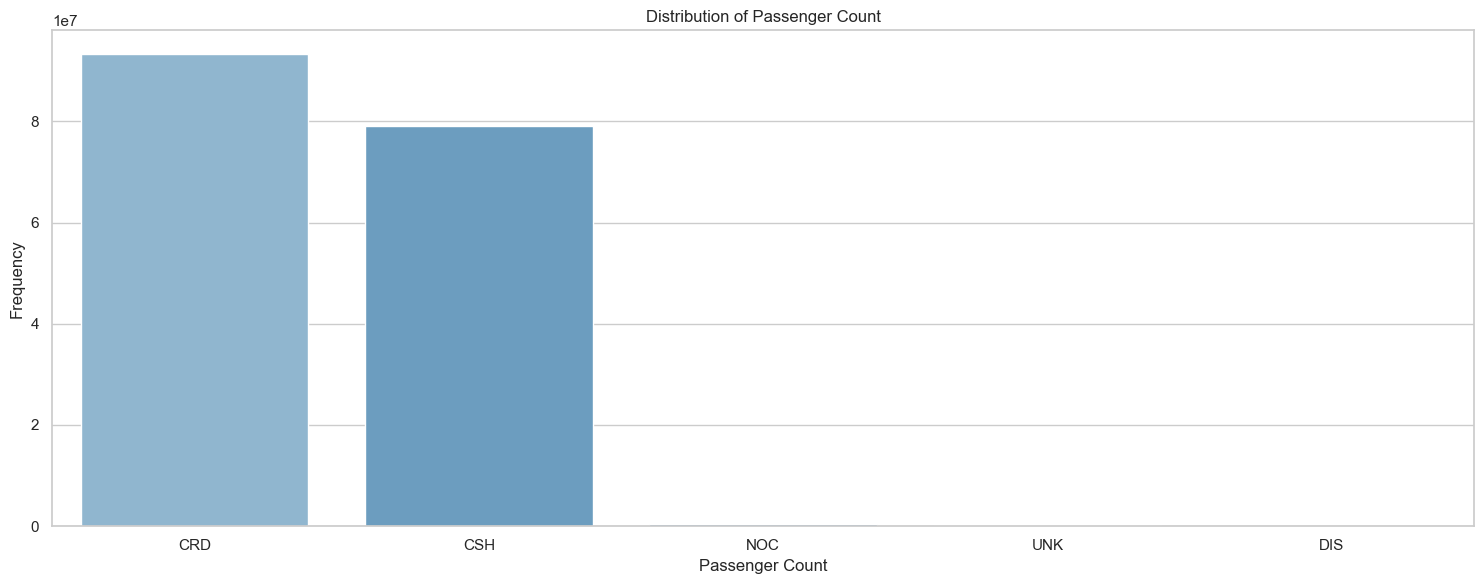

In [103]:
plt.figure(figsize=(15, 6))
sns.barplot(x='payment_type', y='count', data=df_payment_type_count, palette="Blues_d")
plt.title("Distribution of Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [104]:
df_payment_type_count

,payment_type,count
2,CRD,93334004
0,CSH,79110096
4,NOC,401483
3,UNK,206867
1,DIS,127309


In [105]:
card_count = df_payment_type_count[df_payment_type_count['payment_type'] == 'CRD']['count'].iloc[0]
cash_count = df_payment_type_count[df_payment_type_count['payment_type'] == 'CSH']['count'].iloc[0]
total = card_count + cash_count
card_percent = card_count / total
cash_percent = cash_count / total

print(f"Card: {round(card_percent, 2)}%")
print(f"Cash: {round(cash_percent, 2)}%")

Card: 0.54%
Cash: 0.46%
